# Recover Loadings in GDFM with Dynamic PCA

How noisy as spectral density matrix estimates? This notebook simulates factor models with the blockwise VAR representation proved in [Forni et al. (2015)](https://www.sciencedirect.com/science/article/abs/pii/S0304407614002693) recovers loadings using dynamic PCA as suggested in the same paper. 

## Setup

In [2]:
source("../../scripts/GDFM_filter/simulate_stationary_VAR.R")
library(freqdom)

### GDFM 

Let $(x_t^n)_{t \geq 0} \in \mathbb{R}^n$ be a series of observations from an n-dimensional panel of time series admitting dynamic factor model representation, i.e. $x_t^n = \chi_t^n + \xi_t^n$  with common component $\chi_t^n$ being driven by a $Q$-dimensional vector of shocks $u_t$. [Forni et al. (2015)](https://www.sciencedirect.com/science/article/abs/pii/S0304407614002693) showed that the panel model admits the following representation: 

$$\begin{pmatrix}
A_1(L) & \cdots  & 0 \\ 
\vdots  & \ddots  & \vdots \\ 
0 & \cdots  & A_K(L)
\end{pmatrix} \chi_t^n = \begin{pmatrix}
R_1\\ 
\vdots\\ 
R_K
\end{pmatrix} u_t$$

where for $j \in \left \{ 1,.., K \right \}$ it holds that $A_j(L) = \boldsymbol{I} - \left ( \Lambda_{j,1} L + ... + \Lambda_{j,p}L^p \right )$ with each $\Lambda \in \mathbb{R}^{(Q+1)\times(Q+1)}$ and $R_j \in \mathbb{R}^{(Q+1)\times Q}$. The panel of common components can be thought of as K (w.l.o.g. $n \equiv K(Q+1)$) blocks of $(Q+1)$ time series admitting a VAR(Q+1) representation of the form $A_j(L) \chi_t^j = R_j u_t $ with $\chi_t^j \in \mathbb{R}^{Q+1}$ and shocks $u_t$ being common to all blocks. 

### Simulating stationary VARs

Let $X_t \in \mathbb{R}^n$ VAR with representation $\Phi(L)X_t = \boldsymbol{\varepsilon}_t$ or $X_t = \Phi_1X_{t-1} + ... + \Phi_pX_{t-p} + \boldsymbol{\varepsilon}_t$. Necessary and sufficient conditions for the stationarity of $X_t$ are that the eigenvalues for the following matrix lie inside the unit cirlce: 

$$F = \begin{pmatrix}
\Phi_1 & \Phi_2 & \cdots  & \Phi_{p-1} & \Phi_p\\ 
\boldsymbol{I} & \boldsymbol{0} & \cdots  & \boldsymbol{0} & \boldsymbol{0}\\ 
\boldsymbol{0} & \boldsymbol{1} & \cdots  &  \boldsymbol{0} & \boldsymbol{0} \\ 
\vdots  & \vdots  & \ddots  & \vdots  & \vdots \\ 
\boldsymbol{0} & \boldsymbol{0} & \cdots  & \boldsymbol{I} & \boldsymbol{0}
\end{pmatrix}$$

To sample random stationary VAR coeficients consider the singular value decomposition $\left ( \Phi_1, ..., \Phi_p \right ) = U_\Phi \Sigma_\Phi V_\Phi$ where $U_\Phi \in \mathbb{R}^{n \times n}$ and $V_\Phi \in \mathbb{R}^{np \times np}$ are unitary matrices and $\Sigma_\Phi \in \mathbb{R}^{n \times np}$ ir rectangular-diagonal with non-negative values. $U_Phi$ and $V_Phi$ can be sampled from unitary matrices, and to ensure stationarity the diiagonal elements of $\Sigma_\Phi$ can be drawn from the interval $\left ( 0,1 \right )$. 

### Recovering factor model structure

[Barigozzi and Hallain (2018)](https://academic.oup.com/jfec/article-abstract/17/3/462/4915925?redirectedFrom=fulltext) summarize the estimation procedure as follows: 

1. *Filtering:* estimate $\widehat{\Sigma}_{xx}(\theta)$ the spectral debnsity of $x_t^n$ and using the first q dynamic princiapl components estimate $\widehat{\Sigma}_{\chi \chi}(\theta)$ the spectral density matrix of the common component. An inverse fourier transform is used to reconstruct the ACVs of the common component $\left ( \widehat{\Gamma}_\chi (j) \right )_{j \in \mathbb{N} }$. The matrices $A_j(L)$ are then reconstructed by solving low low-dimensional Yule-Walker equations. 
2. *PCA*: the GDFM can be re-cast as a static factor model using $A(L)x_t^n = A(L)\chi_t^n + A(L)\xi_t^n$ giving $Z_t^n = Ru_t + e_t$ with $Z_t^n = A(L)x_t^n$. Parameters in the new static factor model can then be estimated via PCA. 

## Simulations

### Error in spectral norm as $T \rightarrow \infty$

In [12]:
normed_errors <- c()
time_points <- seq(100,10000,200)
pb <- txtProgressBar(min = min(time_points), max = max(time_points), initial = min(time_points), style = 3)

for (T in time_points){
    
    # simulate GDFM
    x <- simulate_GDFM(Q = 2, # dimension of common shocks
                   K = 3, # => n = (2+1)*3 = 9
                   lags = 1, # VAR representation of common comp
                   t = T # time points
                   )
    
    # reconstruct common component
    decomp <- dpca(x$panel, Ndpc = 2)
    S <- fourier.inverse(decomp$spec.density, lags = 0:1)
    
    # reconstruct polynomilas
    ar_coef <- abs(x$AR_coef[[1]][[1]])
    est_coef <- abs(solve(S$operators[1:3,1:3,'lag 0']) %*% S$operators[1:3,1:3,'lag 1'])
    normed_errors <- c(normed_errors, norm(ar_coef - est_coef, type = "2"))
    
    setTxtProgressBar(pb, T)
    } 


  |======================================================================| 100%

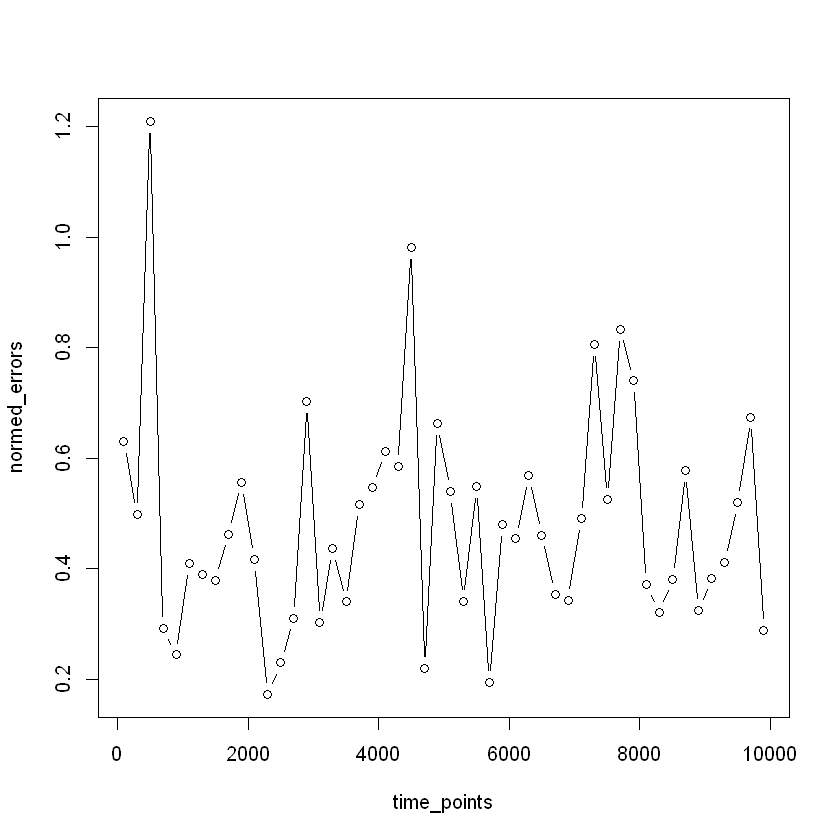

In [13]:
plot(time_points,normed_errors, type = "b")